### Load and See dataset

In [1]:
from datasets import load_dataset

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

model_id = "google/flan-t5-small"
tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipe = pipeline("text2text-generation", model=model, tokenizer=tok, max_new_tokens=8, do_sample=False)

LABELS = ["negative", "neutral", "positive"]

def classify_llm(text):
    prompt = f"Classify the sentiment (negative, neutral, positive). Reply with one word.\n\n{text}"
    out = pipe(prompt)[0]["generated_text"].strip().lower()
    if "neg" in out: return 0
    if "pos" in out: return 2
    return 1


2025-07-23 14:31:35.106825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-23 14:31:35.184093: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 14:31:35.186443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-23 14:31:35.186453: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [17]:

ds = load_dataset("mteb/amazon_reviews_multi", "en")
map3 = {0:0, 1:0, 2:1, 3:2, 4:2}
ds = ds.map(lambda x: {"label3": map3[x["label"]]})

ds = ds.rename_column("text", "sentence")
keep = ["sentence", "label3"]
ds = ds.remove_columns([c for c in ds["train"].column_names if c not in keep])

en/train/0000.parquet:   0%|          | 0.00/28.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/713k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/711k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [19]:
ds['train'][0]

{'sentence': "I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...\n\nArrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
 'label3': 0}

In [20]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_name = "xlm-roberta-base"
tok = AutoTokenizer.from_pretrained(model_name)


def tok_batch(batch):
    return tok(batch["sentence"], truncation=True, padding="max_length", max_length=256)

ds = ds.map(tok_batch, batched=True)
ds = ds.with_format("torch")
train = ds["train"].shuffle(seed=42).select(range(5000))
val   = ds["validation"]
test  = ds["test"]


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [44]:
# train_light_improved.py
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
)
from evaluate import load as load_metric

# ---------------- 0. Setup ----------------
model_name = "distilbert-base-multilingual-cased"
tok = AutoTokenizer.from_pretrained(model_name)
map3 = {0:0, 1:0, 2:1, 3:2, 4:2}

# ---------------- 1. Load + relabel ----------------
ds = load_dataset("mteb/amazon_reviews_multi", "en")
ds = ds.map(lambda x: {"labels": map3[x["label"]]})
ds = ds.rename_column("text", "sentence")
ds = ds.remove_columns([c for c in ds["train"].column_names if c not in ["sentence", "labels"]])

# ---- Stratified sampling helper ----
def stratified_take(split, per_class, seed=42):
    idxs = []
    labels = np.array(split["labels"])
    rng = np.random.default_rng(seed)
    for c in np.unique(labels):
        cand = np.where(labels == c)[0]
        take = min(per_class, len(cand))
        idxs.extend(rng.choice(cand, take, replace=False))
    return split.select(sorted(idxs))

train_raw, val_raw, test_raw = ds["train"], ds["validation"], ds["test"]

train = stratified_take(train_raw.shuffle(seed=42), per_class=2000)   # 6000 total
val   = stratified_take(val_raw.shuffle(seed=42),   per_class=400)    # 1200 total
test  = stratified_take(test_raw.shuffle(seed=42),  per_class=600)    # 1800 total

print("Train:", Counter(train["labels"]))
print("Val  :", Counter(val["labels"]))
print("Test :", Counter(test["labels"]))

# ---------------- 2. Tokenize ----------------
def tok_batch(b):
    return tok(b["sentence"], truncation=True, padding=False, max_length=256)

train = train.map(tok_batch, batched=True)
val   = val.map(tok_batch, batched=True)
test  = test.map(tok_batch, batched=True)

cols = ["input_ids", "attention_mask", "labels"]
for split in (train, val, test):
    split.set_format(type="torch", columns=cols)

# ---------------- 3. Model ----------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Freeze all, unfreeze last 2 layers
for p in model.base_model.parameters():
    p.requires_grad = False
for name, p in model.named_parameters():
    if name.startswith("distilbert.transformer.layer.4") or name.startswith("distilbert.transformer.layer.5"):
        p.requires_grad = True

# ---------------- 4. Class weights ----------------
y_train = np.array(train["labels"])
weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1,2]), y=y_train)
class_w = torch.tensor(weights, dtype=torch.float)

metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"macro_f1": metric.compute(predictions=preds, references=labels, average="macro")["f1"]}

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss_fct = nn.CrossEntropyLoss(weight=class_w.to(outputs.logits.device))
        loss = loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    output_dir="ckpt_light",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=1e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    save_total_limit=2,
    report_to=[],
    no_cuda=True
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tok),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
trainer.save_model("model_en_light_best")
tok.save_pretrained("model_en_light_best")


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Train: Counter({2: 2000, 1: 2000, 0: 2000})
Val  : Counter({2: 400, 1: 400, 0: 400})
Test : Counter({2: 600, 1: 600, 0: 600})


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/selam/miniconda3/envs/py3.8/lib/python3.8/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/tmp/ipykernel_120811/1526063044.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


  0%|          | 0/940 [00:00<?, ?it/s]

{'loss': 1.0262, 'grad_norm': 2.5768327713012695, 'learning_rate': 9.468085106382978e-05, 'epoch': 0.27}
{'loss': 0.818, 'grad_norm': 4.925760746002197, 'learning_rate': 8.936170212765958e-05, 'epoch': 0.53}
{'loss': 0.7522, 'grad_norm': 2.0934362411499023, 'learning_rate': 8.404255319148937e-05, 'epoch': 0.8}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7098554372787476, 'eval_macro_f1': 0.6762838418208087, 'eval_runtime': 54.2879, 'eval_samples_per_second': 22.104, 'eval_steps_per_second': 0.35, 'epoch': 1.0}
{'loss': 0.6855, 'grad_norm': 4.721901893615723, 'learning_rate': 7.872340425531916e-05, 'epoch': 1.06}
{'loss': 0.6048, 'grad_norm': 4.355890274047852, 'learning_rate': 7.340425531914894e-05, 'epoch': 1.33}
{'loss': 0.6389, 'grad_norm': 3.2958993911743164, 'learning_rate': 6.808510638297873e-05, 'epoch': 1.6}
{'loss': 0.6628, 'grad_norm': 3.085366725921631, 'learning_rate': 6.276595744680851e-05, 'epoch': 1.86}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.6757643222808838, 'eval_macro_f1': 0.6932685881370092, 'eval_runtime': 55.5098, 'eval_samples_per_second': 21.618, 'eval_steps_per_second': 0.342, 'epoch': 2.0}
{'loss': 0.5724, 'grad_norm': 3.2668402194976807, 'learning_rate': 5.744680851063831e-05, 'epoch': 2.13}
{'loss': 0.5088, 'grad_norm': 4.140697956085205, 'learning_rate': 5.212765957446809e-05, 'epoch': 2.39}
{'loss': 0.5195, 'grad_norm': 2.4854414463043213, 'learning_rate': 4.680851063829788e-05, 'epoch': 2.66}
{'loss': 0.5444, 'grad_norm': 5.07588005065918, 'learning_rate': 4.148936170212766e-05, 'epoch': 2.93}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7024925947189331, 'eval_macro_f1': 0.6877316069390651, 'eval_runtime': 54.2794, 'eval_samples_per_second': 22.108, 'eval_steps_per_second': 0.35, 'epoch': 3.0}
{'loss': 0.4303, 'grad_norm': 2.772366523742676, 'learning_rate': 3.617021276595745e-05, 'epoch': 3.19}
{'loss': 0.4242, 'grad_norm': 3.459791898727417, 'learning_rate': 3.085106382978723e-05, 'epoch': 3.46}
{'loss': 0.4357, 'grad_norm': 3.6607143878936768, 'learning_rate': 2.5531914893617022e-05, 'epoch': 3.72}
{'loss': 0.3779, 'grad_norm': 5.228521347045898, 'learning_rate': 2.0212765957446807e-05, 'epoch': 3.99}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.7893539667129517, 'eval_macro_f1': 0.6897208441628764, 'eval_runtime': 70.2318, 'eval_samples_per_second': 17.086, 'eval_steps_per_second': 0.271, 'epoch': 4.0}
{'train_runtime': 2004.5177, 'train_samples_per_second': 14.966, 'train_steps_per_second': 0.469, 'train_loss': 0.5995350283511142, 'epoch': 4.0}


('model_en_light_best/tokenizer_config.json',
 'model_en_light_best/special_tokens_map.json',
 'model_en_light_best/vocab.txt',
 'model_en_light_best/added_tokens.json',
 'model_en_light_best/tokenizer.json')

In [ ]:
# test_nb.py (or just a cell)

import torch, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score, classification_report, confusion_matrix

LABELS = ["negative","neutral","positive"]
MAP3 = {0:0, 1:0, 2:1, 3:2, 4:2}

def load_model(path="model_fr_light_best"):
    tok = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path).eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tok, model, device

def batch_predict(texts, tok, model, device, max_len=256, bs=64):
    preds = []
    for i in range(0, len(texts), bs):
        chunk = texts[i:i+bs]
        inputs = tok(chunk, return_tensors="pt", truncation=True,
                     padding=True, max_length=max_len)
        inputs = {k: v.to(device) for k,v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
        preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
    return preds

def eval_model(model_dir="model_fr_light_best", n_test=None, cm_path="confusion_matrix.png"):
    tok, model, device = load_model(model_dir)
    ds = load_dataset("mteb/amazon_reviews_multi", "fr")
    ds = ds.map(lambda x: {"labels": MAP3[x["label"]]})
    test = ds["test"] if n_test is None else ds["test"].select(range(n_test))
    texts = test["text"] if "text" in test.column_names else test["sentence"]
    y_true = test["labels"]
    y_pred = batch_predict(texts, tok, model, device)

    print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
    print(classification_report(y_true, y_pred, target_names=LABELS))

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(LABELS))); ax.set_yticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS); ax.set_yticklabels(LABELS)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(cm_path)
    print(f"Confusion matrix saved to {cm_path}")

Macro F1: 0.6865823492041816
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80      2000
     neutral       0.47      0.41      0.44      1000
    positive       0.81      0.83      0.82      2000

    accuracy                           0.74      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.73      0.74      0.74      5000

Confusion matrix saved to confusion_matrix.png


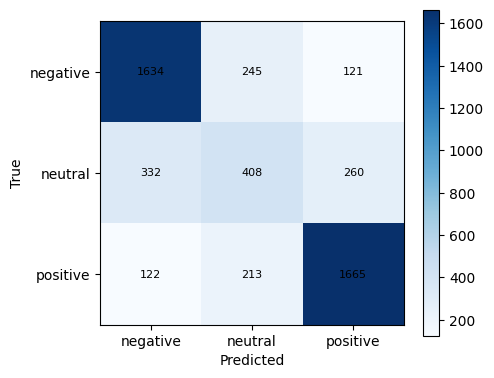

In [48]:
eval_model(n_test=5000)


In [51]:
LABELS = ["negative", "neutral", "positive"]

def predict_one(text, model_dir="model_en_light_best", thresh=0.6):
    tok, model, device = load_model(model_dir)
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        probs = torch.softmax(model(**inputs).logits, dim=1).squeeze().tolist()

    probs_dict = {lab: round(p*100, 2) for lab, p in zip(LABELS, probs)}
    pred = max(probs_dict, key=probs_dict.get)

    # optional: flag low-confidence cases
    confident = probs_dict[pred] >= thresh*100

    return {
        "text": text,
        "prediction": pred,
        "confidence_%": probs_dict[pred],
        "all_probs_%": probs_dict,
        "confident": confident
    }


In [53]:
predict_one("This product is not good.")

{'text': 'This product is not good.',
 'prediction': 'negative',
 'confidence_%': 77.18,
 'all_probs_%': {'negative': 77.18, 'neutral': 20.62, 'positive': 2.21},
 'confident': True}

In [54]:
predict_one("Happy.")

{'text': 'Happy.',
 'prediction': 'positive',
 'confidence_%': 94.45,
 'all_probs_%': {'negative': 0.77, 'neutral': 4.78, 'positive': 94.45},
 'confident': True}

In [57]:
predict_one("Let us go.")

{'text': 'Let us go.',
 'prediction': 'positive',
 'confidence_%': 49.57,
 'all_probs_%': {'negative': 14.61, 'neutral': 35.82, 'positive': 49.57},
 'confident': False}

In [65]:
predict_one("Normal.")

{'text': 'Normal.',
 'prediction': 'neutral',
 'confidence_%': 46.9,
 'all_probs_%': {'negative': 24.32, 'neutral': 46.9, 'positive': 28.77},
 'confident': False}

In [59]:
from collections import Counter
import numpy as np

def label_counts(split):
    # make sure they're plain ints, not tensors
    labs = [int(x) for x in split["labels"]]
    return Counter(labs)

print("Train:", label_counts(train))
print("Val  :", label_counts(val))
print("Test :", label_counts(test))


Train: Counter({2: 2000, 1: 2000, 0: 2000})
Val  : Counter({2: 400, 1: 400, 0: 400})
Test : Counter({2: 600, 1: 600, 0: 600})
